## Load Data

In [33]:
import pandas as pd
import json

# Calculate old and new ms_per_timebin
old_ms_per_timebin = (512 / 44100) * 1000  # Assuming old hop_length was 512
new_ms_per_timebin = (119 / 44100) * 1000

def convert_time(old_time, old_ms_per_timebin, new_ms_per_timebin):
    old_frame = old_time / old_ms_per_timebin
    new_time = old_frame * new_ms_per_timebin
    return new_time

def convert_onsets_offsets(onsets_offsets):
    return {k: [[convert_time(onset, old_ms_per_timebin, new_ms_per_timebin),
                 convert_time(offset, old_ms_per_timebin, new_ms_per_timebin)]
                for onset, offset in v]
            for k, v in onsets_offsets.items()}

# Load the database
db = pd.read_csv("/home/george-vengrovski/Downloads/database.csv")

# Convert 'syllable_onsets/offsets' column from JSON strings to Python objects and apply the conversion
db['syllable_onsets/offsets'] = db['syllable_onsets/offsets'].apply(json.loads).apply(convert_onsets_offsets)

# Function to convert onsets/offsets to seconds
def convert_to_seconds(onsets_offsets):
    return {k: [[onset/1000, offset/1000] for onset, offset in v]
             for k, v in onsets_offsets.items()}

# Convert to seconds
db['syllable_onsets/offsets'] = db['syllable_onsets/offsets'].apply(convert_to_seconds)

# Extract date and time information from file_name
db['datetime'] = db['file_name'].str.extract(r'(\d+_\d+_\d+_\d+_\d+)\.wav$')
db[['month', 'day', 'hour', 'minute', 'second']] = db['datetime'].str.split('_', expand=True).astype(int)

# Display the first few rows and data info
print(db.head())
print(db.info())

# Print a sample of the converted syllable_onsets/offsets for verification
print("\nSample of converted syllable_onsets/offsets:")
print(db['syllable_onsets/offsets'].iloc[0])

# Filter the database for a specific day (e.g., April 9th)
specific_day = (db['month'] == 4) & (db['day'] == 9)
db_april_9th = db[specific_day]

data = db_april_9th['syllable_onsets/offsets'].iloc[0]

# Display the first few rows and data info for the specific day
print("\nData for April 9th:")
print(db_april_9th.head())
print(db_april_9th.info())

# Print a sample of the converted syllable_onsets/offsets for verification
print("\nSample of converted syllable_onsets/offsets for April 9th:")
print(db_april_9th['syllable_onsets/offsets'].iloc[0])


# Save the syllable onset/offset to a txt file called temp
with open('temp.txt', 'w') as f:
    f.write(str(db['syllable_onsets/offsets'].iloc[35812]))


                                           file_name  song_present  \
0  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
1  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
2  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
3  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
4  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   

                             syllable_onsets/offsets    datetime  month  day  \
0  {'8': [[2.55, 2.558095238095238], [2.574285714...  3_4_9_0_28      3    4   
1  {'9': [[3.356825396825397, 3.3595238095238096]...  3_4_9_0_38      3    4   
2  {'9': [[1.1171428571428574, 1.1198412698412699...   3_4_9_1_1      3    4   
3  {'8': [[4.61968253968254, 4.630476190476191], ...  3_4_9_1_30      3    4   
4  {'11': [[1.0847619047619048, 1.087460317460317...  3_4_9_1_48      3    4   

   hour  minute  second  
0     9       0      28  
1     9       0      38  
2     9       1     

## Calculate Quantity of Songs Over Days

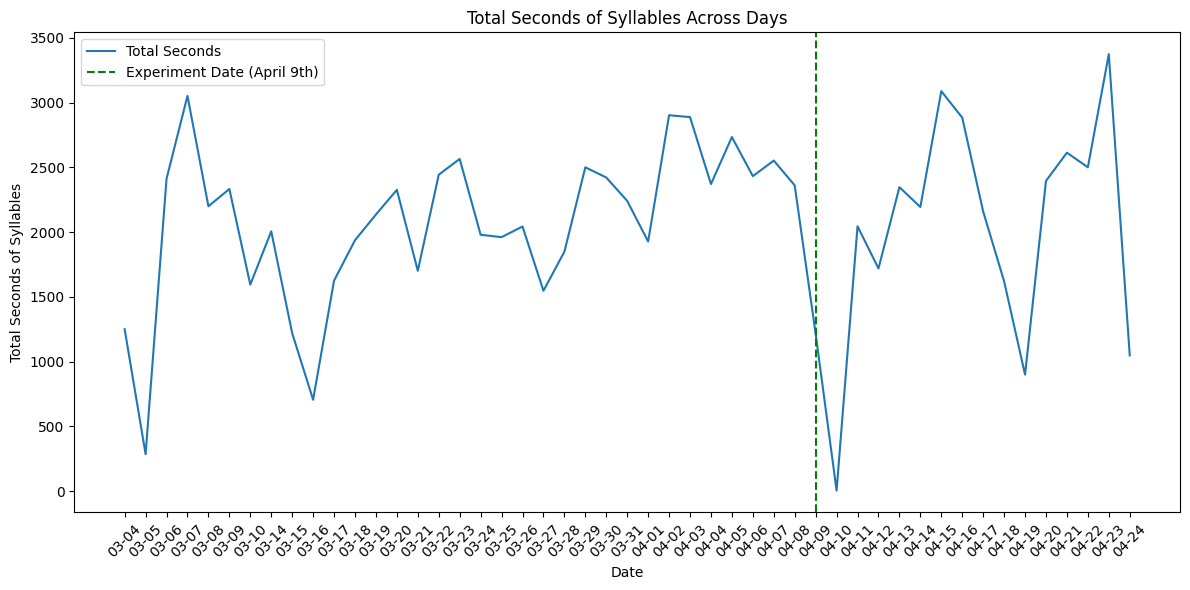

Total seconds of syllables: 100624.55158730158
Average seconds per day: 2053.562277291869
Day with most seconds: date             1900-04-23 00:00:00
total_seconds            3374.235556
Name: 47, dtype: object
Day with least seconds: date             1900-04-10 00:00:00
total_seconds                4.40381
Name: 34, dtype: object


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'db' is already loaded and processed as in the previous code block

# Convert month and day to a date
db['date'] = pd.to_datetime(db['month'].astype(str) + '-' + db['day'].astype(str), format='%m-%d')

# Calculate the total seconds of syllables per day
def calculate_total_seconds(onsets_offsets):
    return sum(offset - onset for times in onsets_offsets.values() for onset, offset in times)

db['total_seconds'] = db['syllable_onsets/offsets'].apply(calculate_total_seconds)

# Sum the total seconds per day
seconds_per_day = db.groupby('date')['total_seconds'].sum().reset_index(name='total_seconds')

# Sort by date
seconds_per_day = seconds_per_day.sort_values('date')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(seconds_per_day['date'].dt.strftime('%m-%d'), seconds_per_day['total_seconds'], label='Total Seconds')

# Add a vertical line for the experiment date (April 9th)
experiment_date = pd.to_datetime('04-09', format='%m-%d')
plt.axvline(x=experiment_date.strftime('%m-%d'), color='g', linestyle='--', label='Experiment Date (April 9th)')

plt.title('Total Seconds of Syllables Across Days')
plt.xlabel('Date')
plt.ylabel('Total Seconds of Syllables')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print("Total seconds of syllables:", seconds_per_day['total_seconds'].sum())
print("Average seconds per day:", seconds_per_day['total_seconds'].mean())
print("Day with most seconds:", seconds_per_day.loc[seconds_per_day['total_seconds'].idxmax()])
print("Day with least seconds:", seconds_per_day.loc[seconds_per_day['total_seconds'].idxmin()])

Original labels shape: (167736,)
Smoothed labels shape: (167736,)

Unique labels in original data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37]
Unique labels in smoothed data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37]

Percentage of data points that changed: 26.10%

Smoothed labels saved to 'smoothed_labels.npz'


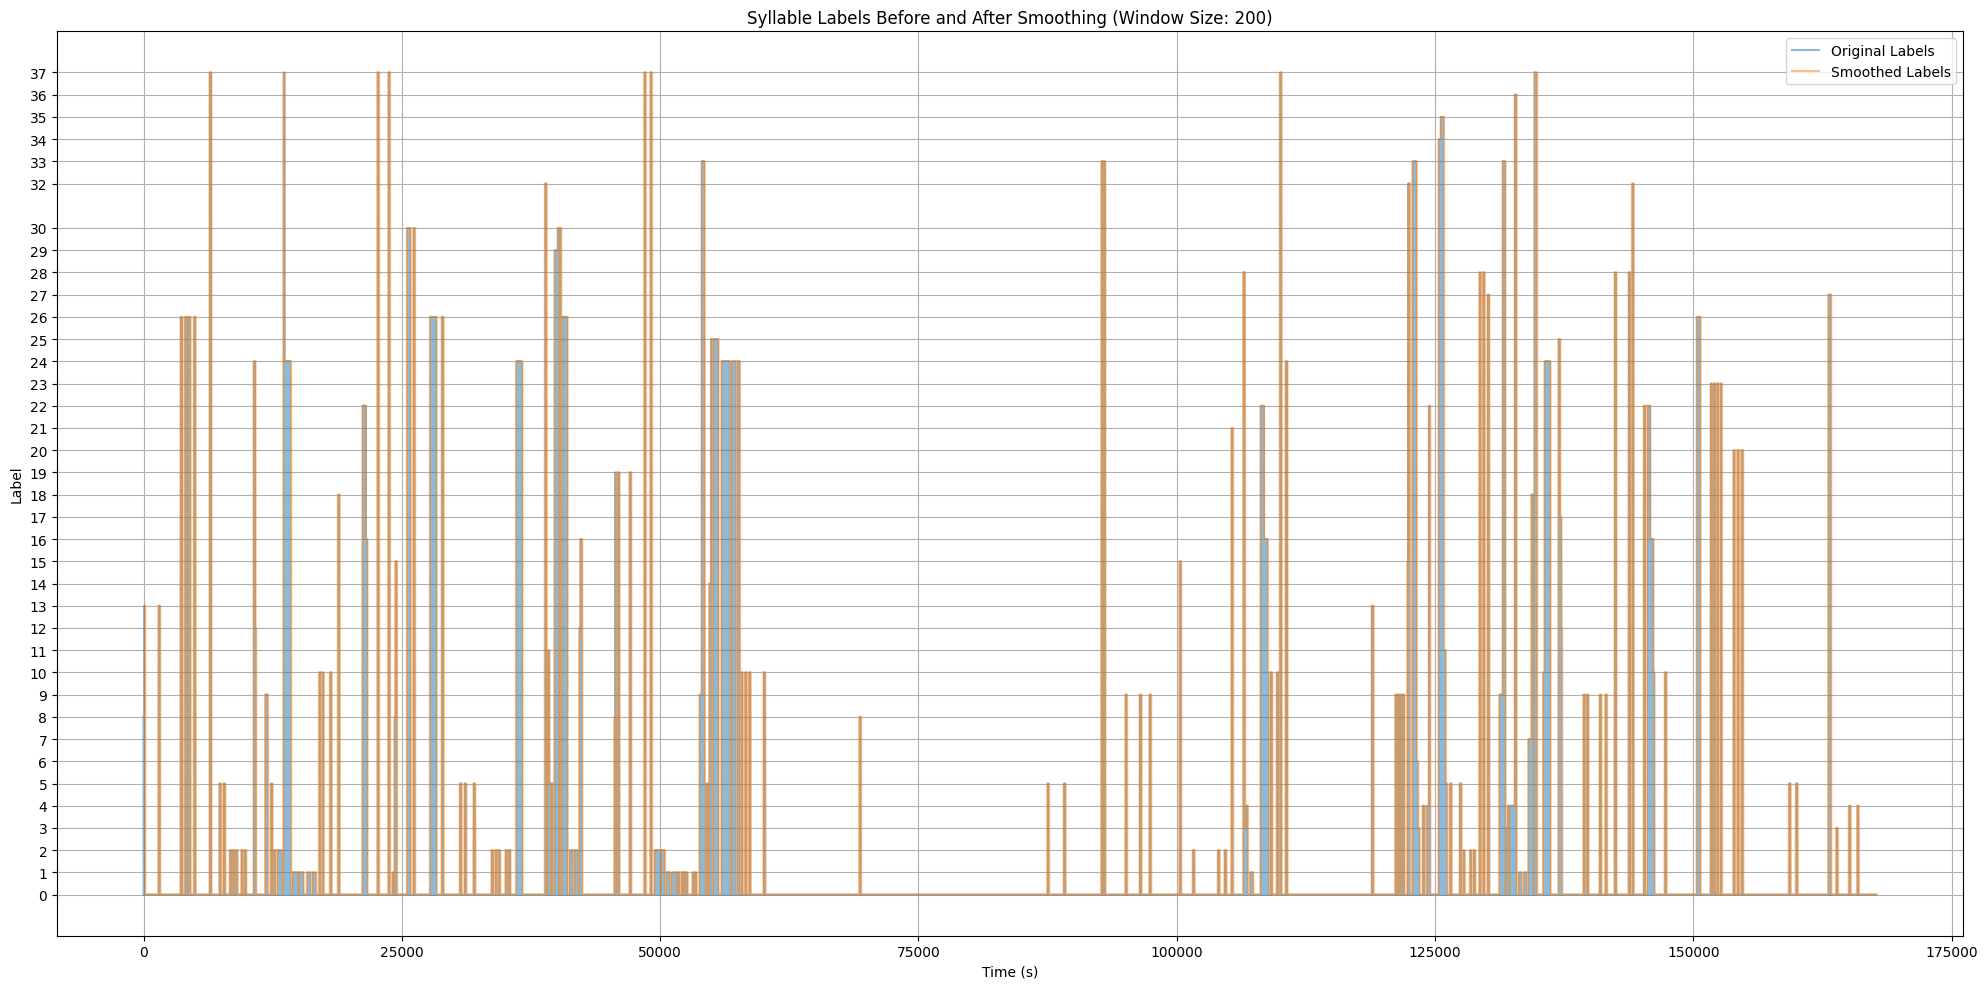


Plot saved as 'labels_comparison.png'


In [3]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def smooth_labels(labels, window_size):
    smoothed_labels = np.copy(labels)
    for i in range(len(labels)):
        start = max(0, i - window_size // 2)
        end = min(len(labels), i + window_size // 2)
        window = labels[start:end]
        window = window[window != 0]  # Exclude silence (0) from the most common calculation
        if len(window) > 0:
            most_common = Counter(window).most_common(1)[0][0]
            smoothed_labels[i] = most_common
        else:
            smoothed_labels[i] = labels[i]
    return smoothed_labels

# Assuming 'db' is your pandas DataFrame
# Create a timeline of syllables with silence (0) between them
timeline = []
for _, row in db.head(50).iterrows():  # Only process the first 1000 songs
    onsets_offsets = row['syllable_onsets/offsets']
    for syllable, times in onsets_offsets.items():
        for onset, offset in times:
            timeline.extend([0] * int(onset))  # Silence before syllable
            timeline.extend([int(syllable)] * (int(offset) - int(onset)))  # Syllable
    timeline.extend([0] * 1000)  # Add 1 second of silence between songs

hdbscan_labels = np.array(timeline)

# Set the window size
window_size = 200

# Apply the sliding window smoothing
smoothed_labels = smooth_labels(hdbscan_labels, window_size)

# Print some statistics
print(f"Original labels shape: {hdbscan_labels.shape}")
print(f"Smoothed labels shape: {smoothed_labels.shape}")
print(f"\nUnique labels in original data: {np.unique(hdbscan_labels)}")
print(f"Unique labels in smoothed data: {np.unique(smoothed_labels)}")

# Calculate and print the percentage of data points that changed
changed_percentage = (hdbscan_labels != smoothed_labels).mean() * 100
print(f"\nPercentage of data points that changed: {changed_percentage:.2f}%")

# Save the smoothed labels
np.savez('smoothed_labels.npz', smoothed_labels=smoothed_labels)
print("\nSmoothed labels saved to 'smoothed_labels.npz'")

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(hdbscan_labels[:500000], label='Original Labels', alpha=0.5)
plt.plot(smoothed_labels[:500000], label='Smoothed Labels', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Label')
plt.title(f'Syllable Labels Before and After Smoothing (Window Size: {window_size})')
plt.legend()
plt.grid(True)

# Adjust y-axis to show integer ticks
y_ticks = sorted(list(set(np.unique(hdbscan_labels)) | set(np.unique(smoothed_labels))))
plt.yticks(y_ticks)

plt.tight_layout()
plt.savefig('labels_comparison.png', dpi=300)
plt.show()

print("\nPlot saved as 'labels_comparison.png'")

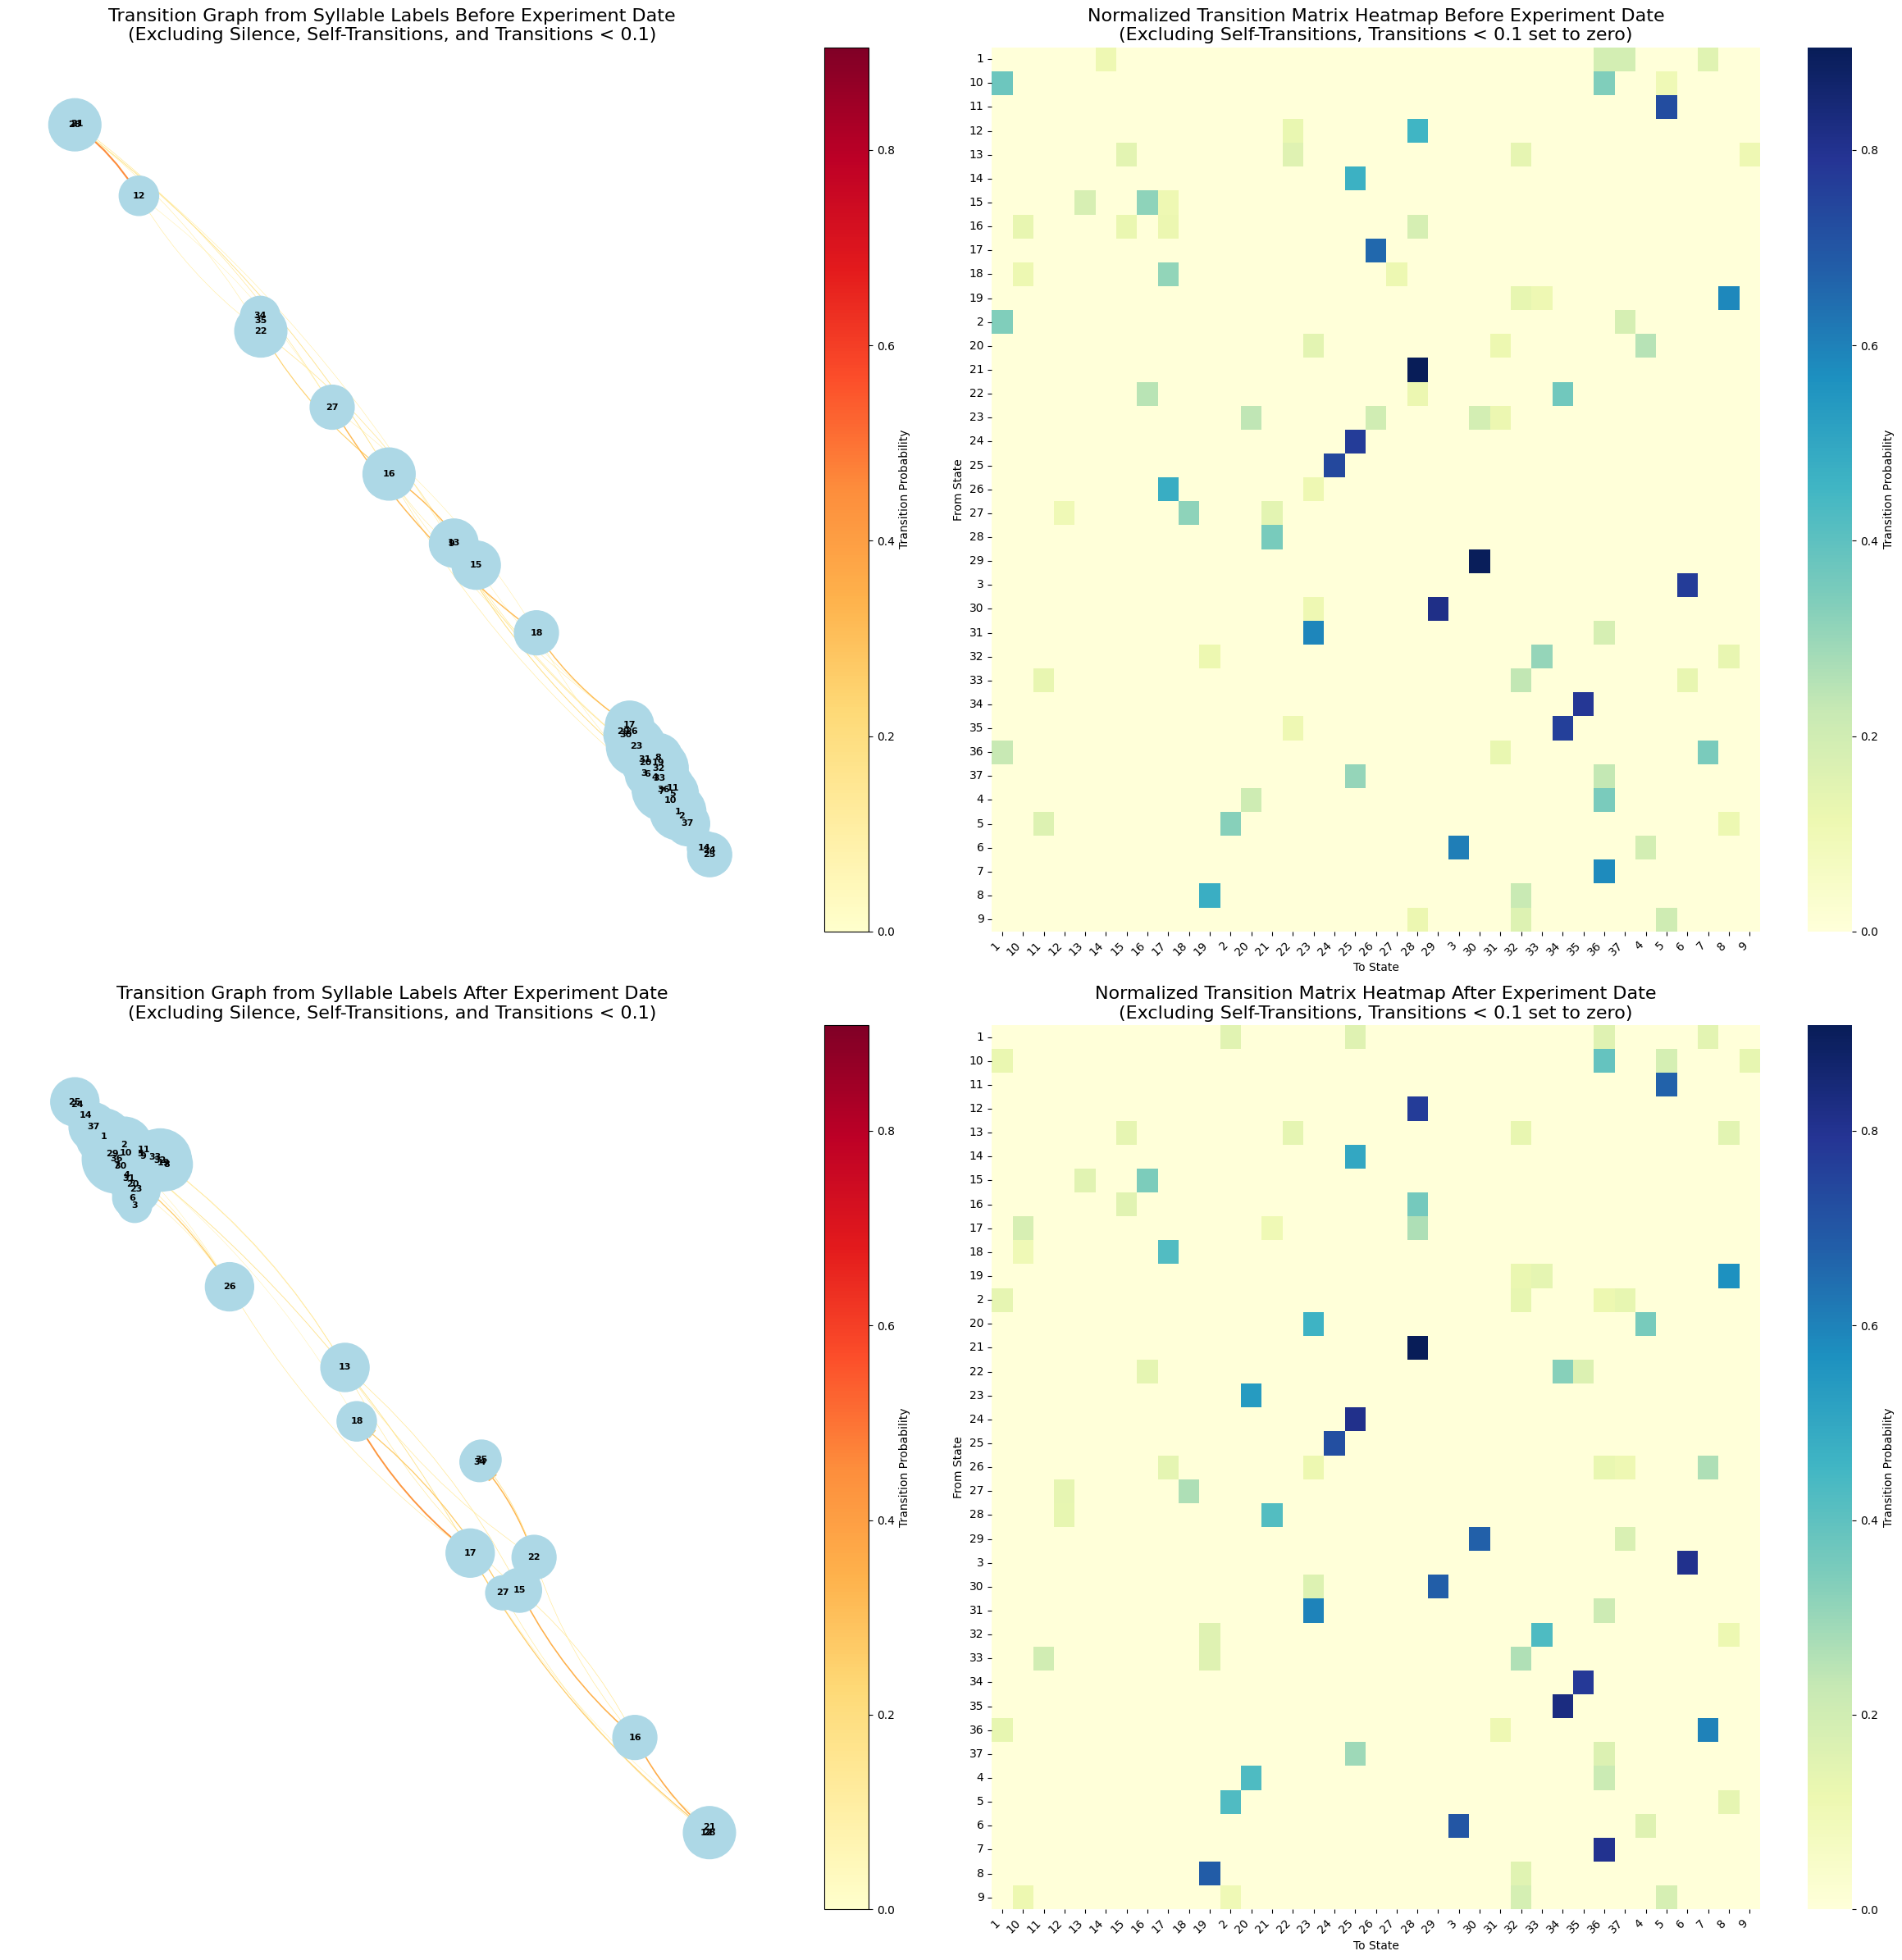

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

def calculate_transition_matrix(db):
    transitions = []
    unique_labels = set()

    for _, row in db.iterrows():
        file_transitions = []
        syllables = row['syllable_onsets/offsets']
        sorted_syllables = sorted([(onset, offset, label) for label, times in syllables.items() for onset, offset in times])
        
        for i in range(len(sorted_syllables) - 1):
            current_label = sorted_syllables[i][2]
            next_label = sorted_syllables[i+1][2]
            if current_label != 'silence' and next_label != 'silence' and current_label != next_label:
                file_transitions.append((current_label, next_label))
                unique_labels.add(current_label)
                unique_labels.add(next_label)
        
        transitions.extend(file_transitions)

    unique_labels = sorted(list(unique_labels))
    transition_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    for from_label, to_label in transitions:
        i = unique_labels.index(from_label)
        j = unique_labels.index(to_label)
        transition_matrix[i, j] += 1

    # Normalize the transition matrix
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix_norm = np.divide(transition_matrix, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis]!=0)

    # Set small transitions to zero for better visualization
    transition_matrix_norm[transition_matrix_norm < 0.1] = 0

    return transition_matrix_norm, unique_labels

# Assuming 'db' is already loaded and processed as in the previous code block

# Convert month and day to a date
db['date'] = pd.to_datetime(db['month'].astype(str) + '-' + db['day'].astype(str), format='%m-%d')

# Define the experiment date
experiment_date = pd.to_datetime('04-09', format='%m-%d')

# Split the data into before and after the experiment date
db_before = db[db['date'] < experiment_date]
db_after = db[db['date'] >= experiment_date]

# Calculate the transition matrix for data before the experiment date
transition_matrix_norm_before, unique_labels_before = calculate_transition_matrix(db_before)

# Calculate the transition matrix for data after the experiment date
transition_matrix_norm_after, unique_labels_after = calculate_transition_matrix(db_after)

# Create graphs
G_before = nx.DiGraph()
G_after = nx.DiGraph()

# Add nodes for before
for label in unique_labels_before:
    G_before.add_node(label)

# Add edges for before (excluding self-edges)
for i, from_label in enumerate(unique_labels_before):
    for j, to_label in enumerate(unique_labels_before):
        if i != j:  # Exclude self-edges
            weight = transition_matrix_norm_before[i, j]
            if weight > 0:
                G_before.add_edge(from_label, to_label, weight=weight)

# Add nodes for after
for label in unique_labels_after:
    G_after.add_node(label)

# Add edges for after (excluding self-edges)
for i, from_label in enumerate(unique_labels_after):
    for j, to_label in enumerate(unique_labels_after):
        if i != j:  # Exclude self-edges
            weight = transition_matrix_norm_after[i, j]
            if weight > 0:
                G_after.add_edge(from_label, to_label, weight=weight)

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(24, 24))

# Improve graph layout for before
pos_before = nx.spring_layout(G_before, k=0.1, iterations=500)

# Adjust node sizes based on their degree for before
node_sizes_before = [300 * (1 + G_before.degree(node)) for node in G_before.nodes()]

# Adjust edge widths based on their weight for before
edge_weights_before = [G_before[u][v]['weight'] for u, v in G_before.edges()]
max_weight_before = max(edge_weights_before) if edge_weights_before else 1
normalized_weights_before = [w / max_weight_before for w in edge_weights_before]

# Use a colormap for edges for before
edge_colors_before = plt.cm.YlOrRd(normalized_weights_before)

# Plot graph with improved styling for before
nx.draw_networkx_nodes(G_before, pos_before, node_size=node_sizes_before, node_color='lightblue', ax=axes[0, 0])
nx.draw_networkx_labels(G_before, pos_before, font_size=8, font_weight='bold', ax=axes[0, 0])
nx.draw_networkx_edges(G_before, pos_before, width=[w * 3 for w in normalized_weights_before], 
                       edge_color=edge_colors_before, arrows=True, 
                       arrowsize=20, ax=axes[0, 0], connectionstyle="arc3,rad=0.1")

# Add a colorbar for edge weights for before
sm_before = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=max_weight_before))
sm_before.set_array([])
cbar_before = plt.colorbar(sm_before, ax=axes[0, 0], label='Transition Probability')

axes[0, 0].set_title("Transition Graph from Syllable Labels Before Experiment Date\n(Excluding Silence, Self-Transitions, and Transitions < 0.1)", fontsize=16)
axes[0, 0].axis('off')

# Plot transition matrix as heatmap without numbers for before
sns.heatmap(transition_matrix_norm_before, cmap='YlGnBu', ax=axes[0, 1], cbar_kws={'label': 'Transition Probability'})
axes[0, 1].set_title("Normalized Transition Matrix Heatmap Before Experiment Date\n(Excluding Self-Transitions, Transitions < 0.1 set to zero)", fontsize=16)
axes[0, 1].set_xlabel("To State")
axes[0, 1].set_ylabel("From State")
axes[0, 1].set_xticklabels(unique_labels_before, rotation=45, ha='right')
axes[0, 1].set_yticklabels(unique_labels_before, rotation=0)

# Improve graph layout for after
pos_after = nx.spring_layout(G_after, k=0.1, iterations=500)

# Adjust node sizes based on their degree for after
node_sizes_after = [300 * (1 + G_after.degree(node)) for node in G_after.nodes()]

# Adjust edge widths based on their weight for after
edge_weights_after = [G_after[u][v]['weight'] for u, v in G_after.edges()]
max_weight_after = max(edge_weights_after) if edge_weights_after else 1
normalized_weights_after = [w / max_weight_after for w in edge_weights_after]

# Use a colormap for edges for after
edge_colors_after = plt.cm.YlOrRd(normalized_weights_after)

# Plot graph with improved styling for after
nx.draw_networkx_nodes(G_after, pos_after, node_size=node_sizes_after, node_color='lightblue', ax=axes[1, 0])
nx.draw_networkx_labels(G_after, pos_after, font_size=8, font_weight='bold', ax=axes[1, 0])
nx.draw_networkx_edges(G_after, pos_after, width=[w * 3 for w in normalized_weights_after], 
                       edge_color=edge_colors_after, arrows=True, 
                       arrowsize=20, ax=axes[1, 0], connectionstyle="arc3,rad=0.1")

# Add a colorbar for edge weights for after
sm_after = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=max_weight_after))
sm_after.set_array([])
cbar_after = plt.colorbar(sm_after, ax=axes[1, 0], label='Transition Probability')

axes[1, 0].set_title("Transition Graph from Syllable Labels After Experiment Date\n(Excluding Silence, Self-Transitions, and Transitions < 0.1)", fontsize=16)
axes[1, 0].axis('off')

# Plot transition matrix as heatmap without numbers for after
sns.heatmap(transition_matrix_norm_after, cmap='YlGnBu', ax=axes[1, 1], cbar_kws={'label': 'Transition Probability'})
axes[1, 1].set_title("Normalized Transition Matrix Heatmap After Experiment Date\n(Excluding Self-Transitions, Transitions < 0.1 set to zero)", fontsize=16)
axes[1, 1].set_xlabel("To State")
axes[1, 1].set_ylabel("From State")
axes[1, 1].set_xticklabels(unique_labels_after, rotation=45, ha='right')
axes[1, 1].set_yticklabels(unique_labels_after, rotation=0)

plt.tight_layout()
plt.show()

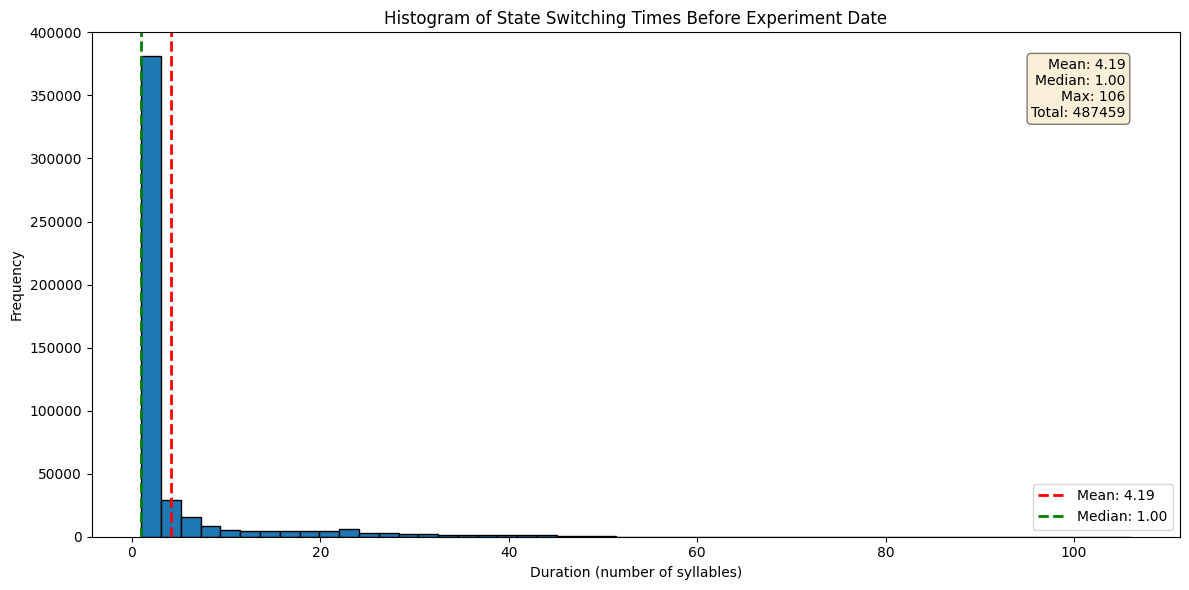

Histogram of State Switching Times Before Experiment Date
Mean switching time: 4.19
Median switching time: 1.00
Maximum switching time: 106
Total number of switches: 487459


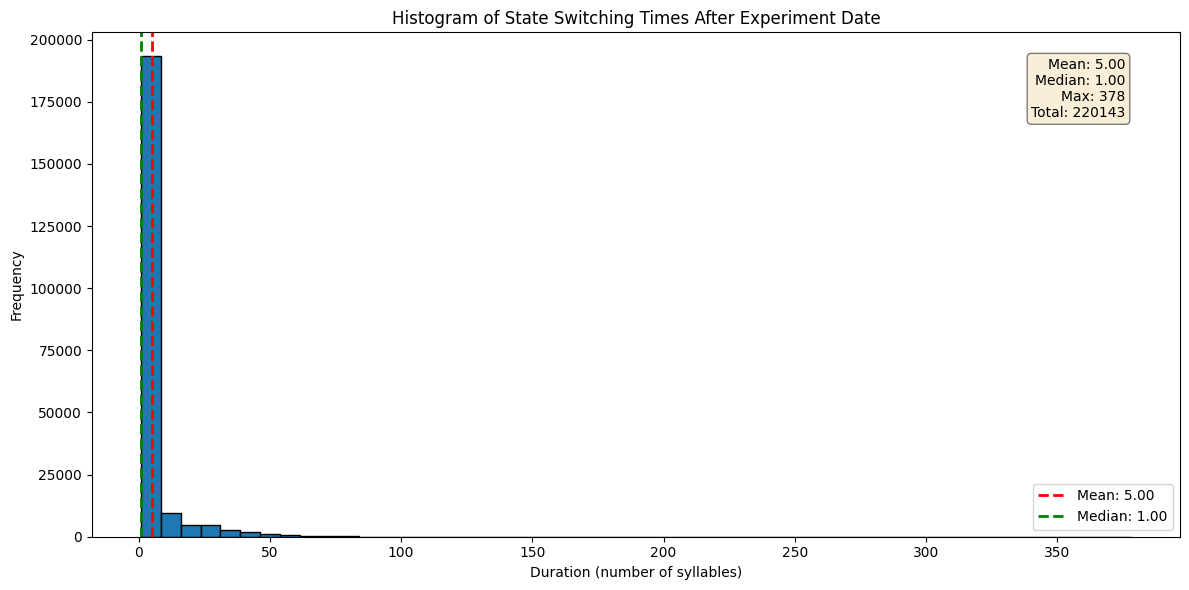

Histogram of State Switching Times After Experiment Date
Mean switching time: 5.00
Median switching time: 1.00
Maximum switching time: 378
Total number of switches: 220143


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'db' is already loaded and processed as in the previous code block

# Convert month and day to a date
db['date'] = pd.to_datetime(db['month'].astype(str) + '-' + db['day'].astype(str), format='%m-%d')

# Define the experiment date
experiment_date = pd.to_datetime('04-09', format='%m-%d')

# Split the data into before and after the experiment date
db_before = db[db['date'] < experiment_date]
db_after = db[db['date'] >= experiment_date]

def calculate_switching_times(db):
    all_labels = []
    for _, row in db.iterrows():
        syllables = row['syllable_onsets/offsets']
        sorted_syllables = sorted([(onset, label) for label, times in syllables.items() for onset, _ in times])
        all_labels.extend([label for _, label in sorted_syllables])

    # Calculate switching times
    switching_times = []
    if all_labels:
        current_state = all_labels[0]
        current_duration = 1

        for label in all_labels[1:]:
            if label == current_state:
                current_duration += 1
            else:
                switching_times.append(current_duration)
                current_state = label
                current_duration = 1

        # Add the last state duration if it hasn't switched at the end
        if current_duration > 1:
            switching_times.append(current_duration)

    return np.array(switching_times)

# Calculate switching times for before and after the experiment date
switching_times_before = calculate_switching_times(db_before)
switching_times_after = calculate_switching_times(db_after)

def plot_switching_times_histogram(switching_times, title, filename):
    # Calculate some statistics
    mean_time = np.mean(switching_times)
    median_time = np.median(switching_times)
    max_time = np.max(switching_times)
    total_switches = len(switching_times)

    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(switching_times, bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel('Duration (number of syllables)')
    plt.ylabel('Frequency')

    # Add vertical lines for mean and median
    plt.axvline(mean_time, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f}')
    plt.axvline(median_time, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f}')

    plt.legend()

    # Add text box with statistics
    stats_text = f'Mean: {mean_time:.2f}\nMedian: {median_time:.2f}\nMax: {max_time}\nTotal: {total_switches}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top',
             horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"{title}")
    print(f"Mean switching time: {mean_time:.2f}")
    print(f"Median switching time: {median_time:.2f}")
    print(f"Maximum switching time: {max_time}")
    print(f"Total number of switches: {total_switches}")

# Plot histograms for before and after the experiment date
plot_switching_times_histogram(switching_times_before, 'Histogram of State Switching Times Before Experiment Date', 'switching_times_histogram_before.png')
plot_switching_times_histogram(switching_times_after, 'Histogram of State Switching Times After Experiment Date', 'switching_times_histogram_after.png')

### Comparing Three Groups, before surgery vs dos -1, after surgery vs dos -2

Mean phrase time for 0-4 Days Prior: 35.58 ± 0.16
Mean phrase time for 4-8 Days Prior: 35.59 ± 0.16
Mean phrase time for 0-4 Days Post: 49.60 ± 1.01


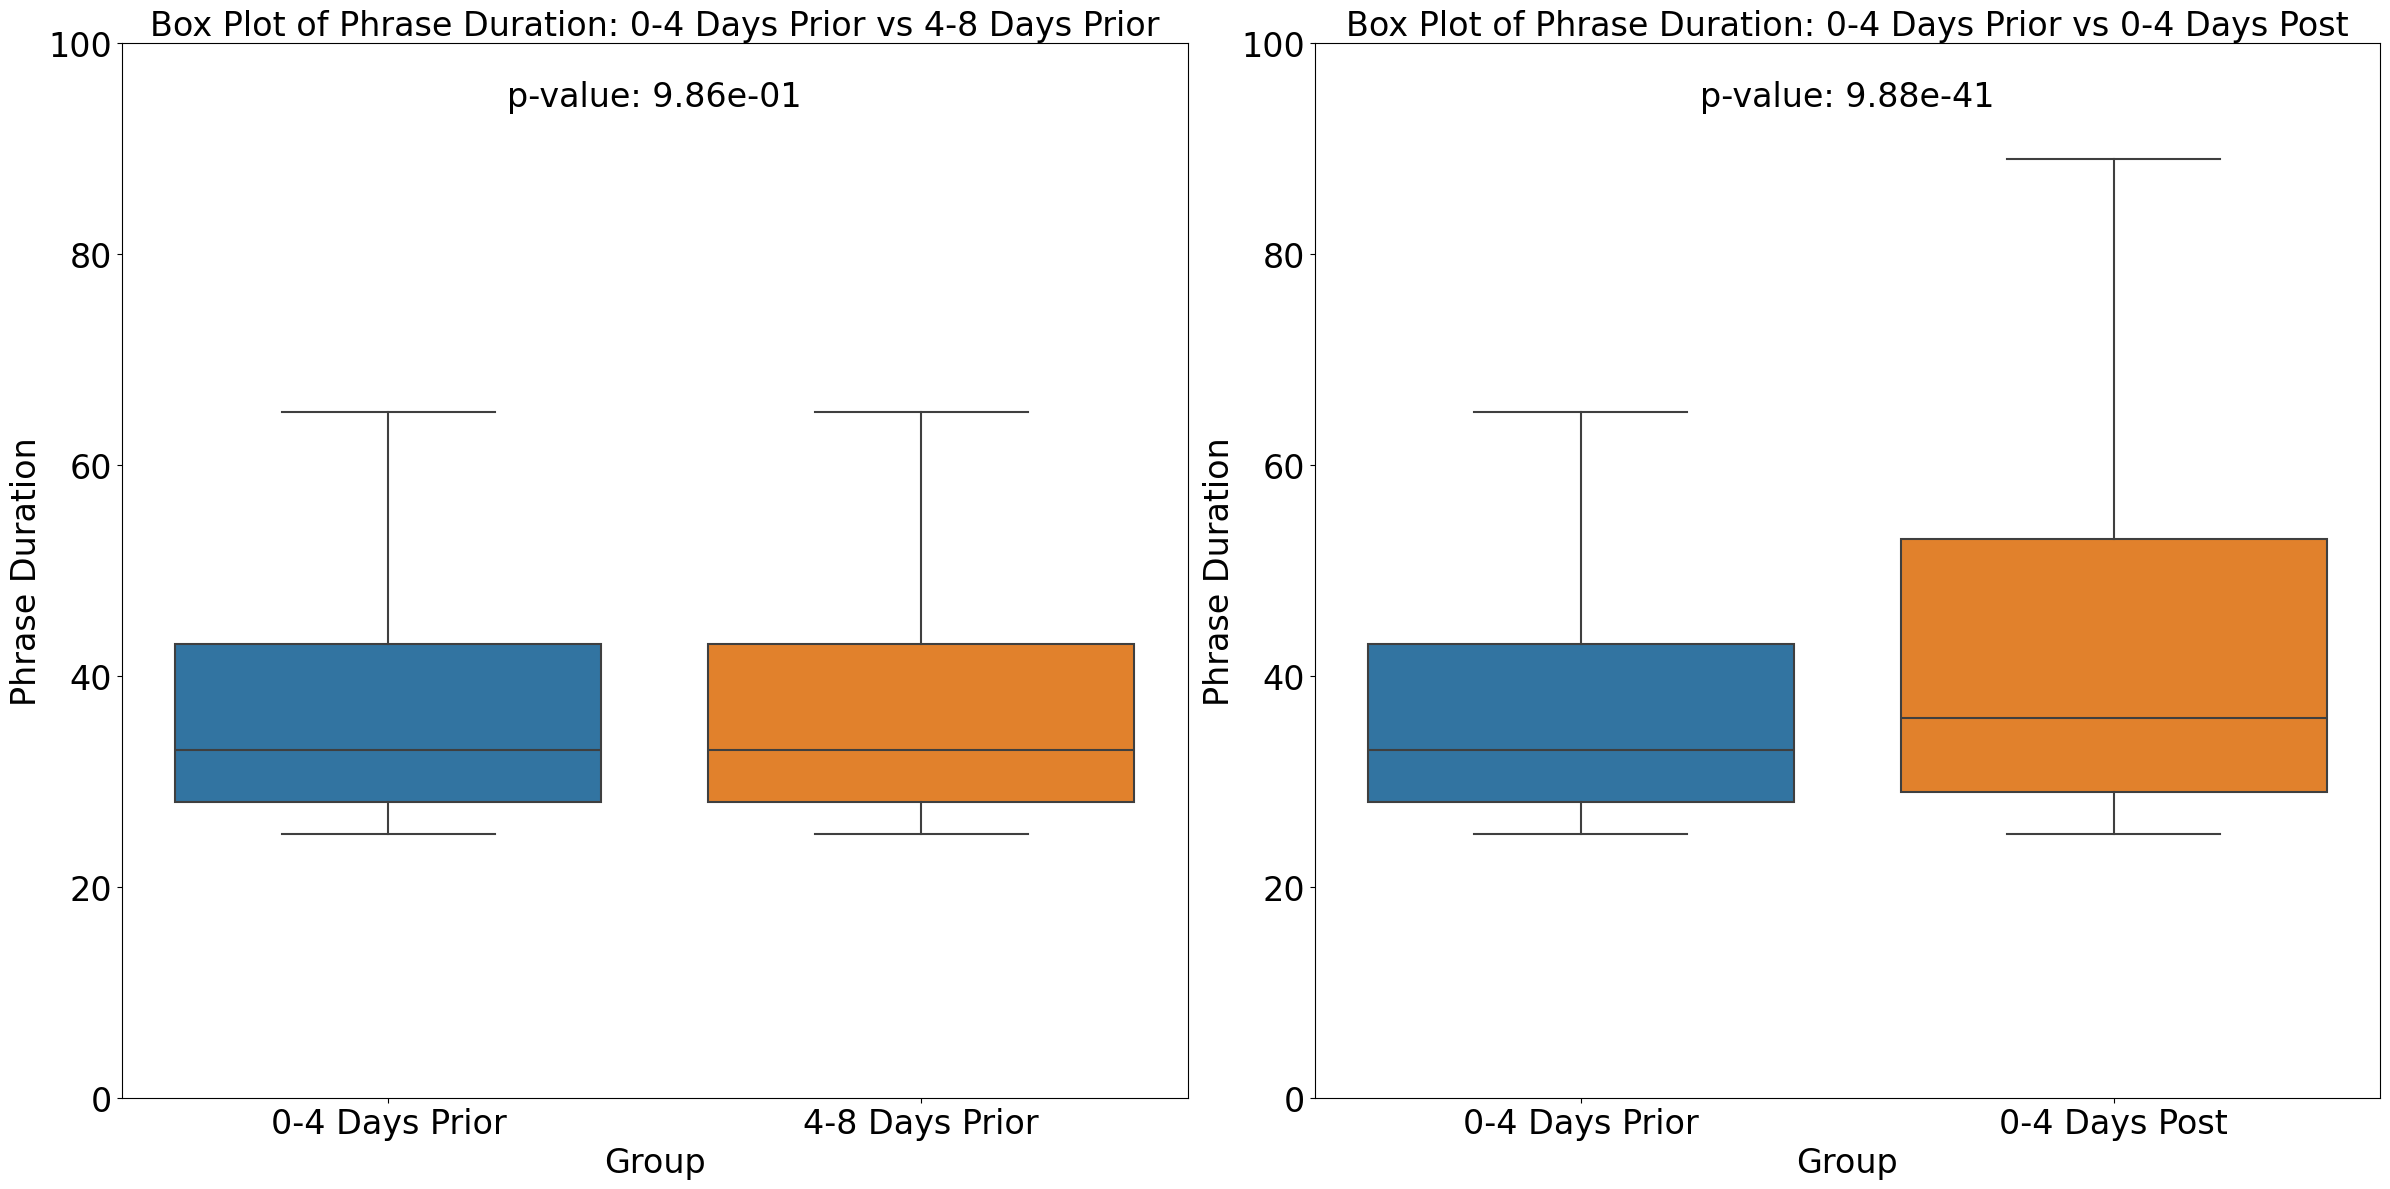

T-test result for prior comparison: t-statistic = -0.02, p-value = 9.86e-01
T-test result for post comparison: t-statistic = -13.72, p-value = 9.88e-41
Standard deviation for 0-4 Days Prior: 8.85
Standard deviation for 4-8 Days Prior: 9.20
Standard deviation for 0-4 Days Post: 40.88
Mean for 0-4 Days Prior: 35.58
Mean for 4-8 Days Prior: 35.59
Mean for 0-4 Days Post: 49.60


In [9]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Calculate old and new ms_per_timebin
old_ms_per_timebin = (512 / 44100) * 1000  # Assuming old hop_length was 512
new_ms_per_timebin = (119 / 44100) * 1000

def convert_time(old_time, old_ms_per_timebin, new_ms_per_timebin):
    old_frame = old_time / old_ms_per_timebin
    new_time = old_frame * new_ms_per_timebin
    return new_time

def convert_onsets_offsets(onsets_offsets):
    return {k: [[convert_time(onset, old_ms_per_timebin, new_ms_per_timebin),
                 convert_time(offset, old_ms_per_timebin, new_ms_per_timebin)]
                for onset, offset in v]
            for k, v in onsets_offsets.items()}

# Load the database
db = pd.read_csv("/home/george-vengrovski/Downloads/database.csv")

# Convert 'syllable_onsets/offsets' column from JSON strings to Python objects and apply the conversion
db['syllable_onsets/offsets'] = db['syllable_onsets/offsets'].apply(json.loads).apply(convert_onsets_offsets)

# Extract date and time information from file_name
db['datetime'] = db['file_name'].str.extract(r'(\d+_\d+_\d+_\d+_\d+)\.wav$')
db[['month', 'day', 'hour', 'minute', 'second']] = db['datetime'].str.split('_', expand=True).astype(int)

# Convert month and day to a date
db['date'] = pd.to_datetime(db['month'].astype(str) + '-' + db['day'].astype(str), format='%m-%d')

# Define the experiment date
experiment_date = pd.to_datetime('04-09', format='%m-%d')

# Acquire three groups of rows
db_4_days_prior = db[(db['date'] >= experiment_date - pd.Timedelta(days=4)) & (db['date'] < experiment_date)]
db_4_to_8_days_prior = db[(db['date'] >= experiment_date - pd.Timedelta(days=8)) & (db['date'] < experiment_date - pd.Timedelta(days=4))]
db_4_days_post = db[(db['date'] > experiment_date) & (db['date'] <= experiment_date + pd.Timedelta(days=4))]

def calculate_switching_times(db):
    all_labels = []
    for _, row in db.iterrows():
        syllables = row['syllable_onsets/offsets']
        sorted_syllables = sorted([(onset, label) for label, times in syllables.items() for onset, _ in times])
        all_labels.extend([label for _, label in sorted_syllables])

    # Calculate switching times
    switching_times = []
    if all_labels:
        current_state = all_labels[0]
        current_duration = 1

        for label in all_labels[1:]:
            if label == current_state:
                current_duration += 1
            else:
                if current_duration >= 25:  # Filter out states under 25 ms
                    switching_times.append(current_duration)
                current_state = label
                current_duration = 1

        # Add the last state duration if it hasn't switched at the end
        if current_duration >= 5:
            switching_times.append(current_duration)

    return np.array(switching_times)

# Calculate switching times for the three groups
switching_times_4_days_prior = calculate_switching_times(db_4_days_prior)
switching_times_4_to_8_days_prior = calculate_switching_times(db_4_to_8_days_prior)
switching_times_4_days_post = calculate_switching_times(db_4_days_post)

# Combine data for plotting
data_prior = {
    'Switching Times': np.concatenate([switching_times_4_days_prior, switching_times_4_to_8_days_prior]),
    'Group': (['0-4 Days Prior'] * len(switching_times_4_days_prior)) + 
             (['4-8 Days Prior'] * len(switching_times_4_to_8_days_prior))
}

data_post = {
    'Switching Times': np.concatenate([switching_times_4_days_prior, switching_times_4_days_post]),
    'Group': (['0-4 Days Prior'] * len(switching_times_4_days_prior)) + 
             (['0-4 Days Post'] * len(switching_times_4_days_post))
}

df_prior = pd.DataFrame(data_prior)
df_post = pd.DataFrame(data_post)

# Statistical test to check for significant differences
t_stat_prior, p_value_prior = ttest_ind(switching_times_4_days_prior, switching_times_4_to_8_days_prior, equal_var=False)
t_stat_post, p_value_post = ttest_ind(switching_times_4_days_prior, switching_times_4_days_post, equal_var=False)

# Calculate means and standard errors
mean_4_days_prior = np.mean(switching_times_4_days_prior)
mean_4_to_8_days_prior = np.mean(switching_times_4_to_8_days_prior)
mean_4_days_post = np.mean(switching_times_4_days_post)

stderr_4_days_prior = np.std(switching_times_4_days_prior) / np.sqrt(len(switching_times_4_days_prior))
stderr_4_to_8_days_prior = np.std(switching_times_4_to_8_days_prior) / np.sqrt(len(switching_times_4_to_8_days_prior))
stderr_4_days_post = np.std(switching_times_4_days_post) / np.sqrt(len(switching_times_4_days_post))

# Print means and standard errors
print(f"Mean switching time for 0-4 Days Prior: {mean_4_days_prior:.2f} ± {stderr_4_days_prior:.2f}")
print(f"Mean switching time for 4-8 Days Prior: {mean_4_to_8_days_prior:.2f} ± {stderr_4_to_8_days_prior:.2f}")
print(f"Mean switching time for 0-4 Days Post: {mean_4_days_post:.2f} ± {stderr_4_days_post:.2f}")

# Determine the y-axis limits
y_min = min(np.min(switching_times_4_days_prior), np.min(switching_times_4_to_8_days_prior), np.min(switching_times_4_days_post))
y_max = max(np.max(switching_times_4_days_prior), np.max(switching_times_4_to_8_days_prior), np.max(switching_times_4_days_post))
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
sns.boxplot(x='Group', y='Switching Times', data=df_prior, showfliers=False)  # Corrected column name
plt.title('Box Plot of Switching Time: 0-4 Days Prior vs 4-8 Days Prior', fontsize=24)
plt.xlabel('Group', fontsize=24)
plt.ylabel('Switching Time', fontsize=24)
plt.ylim(0, 100)  # Set consistent y-axis limits
plt.xticks(fontsize=24)  # Make x tick label larger
plt.yticks(fontsize=24)  # Make y tick label larger
plt.tight_layout()

# Add p-value information
ax = plt.gca()
ax.text(0.5, 0.95, f'p-value: {p_value_prior:.2e}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=24, color='black')

plt.subplot(1, 2, 2)
sns.boxplot(x='Group', y='Switching Times', data=df_post, showfliers=False)  # Corrected column name
plt.title('Box Plot of Switching Time: 0-4 Days Prior vs 0-4 Days Post', fontsize=24)
plt.xlabel('Group', fontsize=24)
plt.ylabel('Switching Time', fontsize=24)
plt.ylim(0, 100)  # Set consistent y-axis limits
plt.xticks(fontsize=24)  # Make x tick label larger
plt.yticks(fontsize=24)  # Make y tick label larger
plt.tight_layout()

# Add p-value information
ax = plt.gca()
ax.text(0.5, 0.95, f'p-value: {p_value_post:.2e}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=24, color='black')

plt.savefig('switching_times_boxplot_combined.png', dpi=300)
plt.show()

print(f"T-test result for prior comparison: t-statistic = {t_stat_prior:.2f}, p-value = {p_value_prior:.2e}")
print(f"T-test result for post comparison: t-statistic = {t_stat_post:.2f}, p-value = {p_value_post:.2e}")

# Print standard deviations and means for the three groups
std_4_days_prior = np.std(switching_times_4_days_prior)
std_4_to_8_days_prior = np.std(switching_times_4_to_8_days_prior)
std_4_days_post = np.std(switching_times_4_days_post)

print(f"Standard deviation for 0-4 Days Prior: {std_4_days_prior:.2f}")
print(f"Standard deviation for 4-8 Days Prior: {std_4_to_8_days_prior:.2f}")
print(f"Standard deviation for 0-4 Days Post: {std_4_days_post:.2f}")

print(f"Mean for 0-4 Days Prior: {mean_4_days_prior:.2f}")
print(f"Mean for 4-8 Days Prior: {mean_4_to_8_days_prior:.2f}")
print(f"Mean for 0-4 Days Post: {mean_4_days_post:.2f}")